# Randomness Audit: Interpreting Lottery Patterns

This notebook audits common interpretations of lottery data by examining
how randomness behaves over different time horizons and how statistical
assumptions influence conclusions.

## 1. What People Expect Randomness to Look Like

A common misconception is that random systems should produce
flat, evenly spaced, and visually uniform outcomes.

In practice, truly random processes often generate clusters,
gaps, and short-term streaks that appear meaningful to the human eye.

## 2. Visual Evidence of Randomness Illusions

To illustrate how randomness can appear patterned,
we compare long-run distributions with short-term windows.


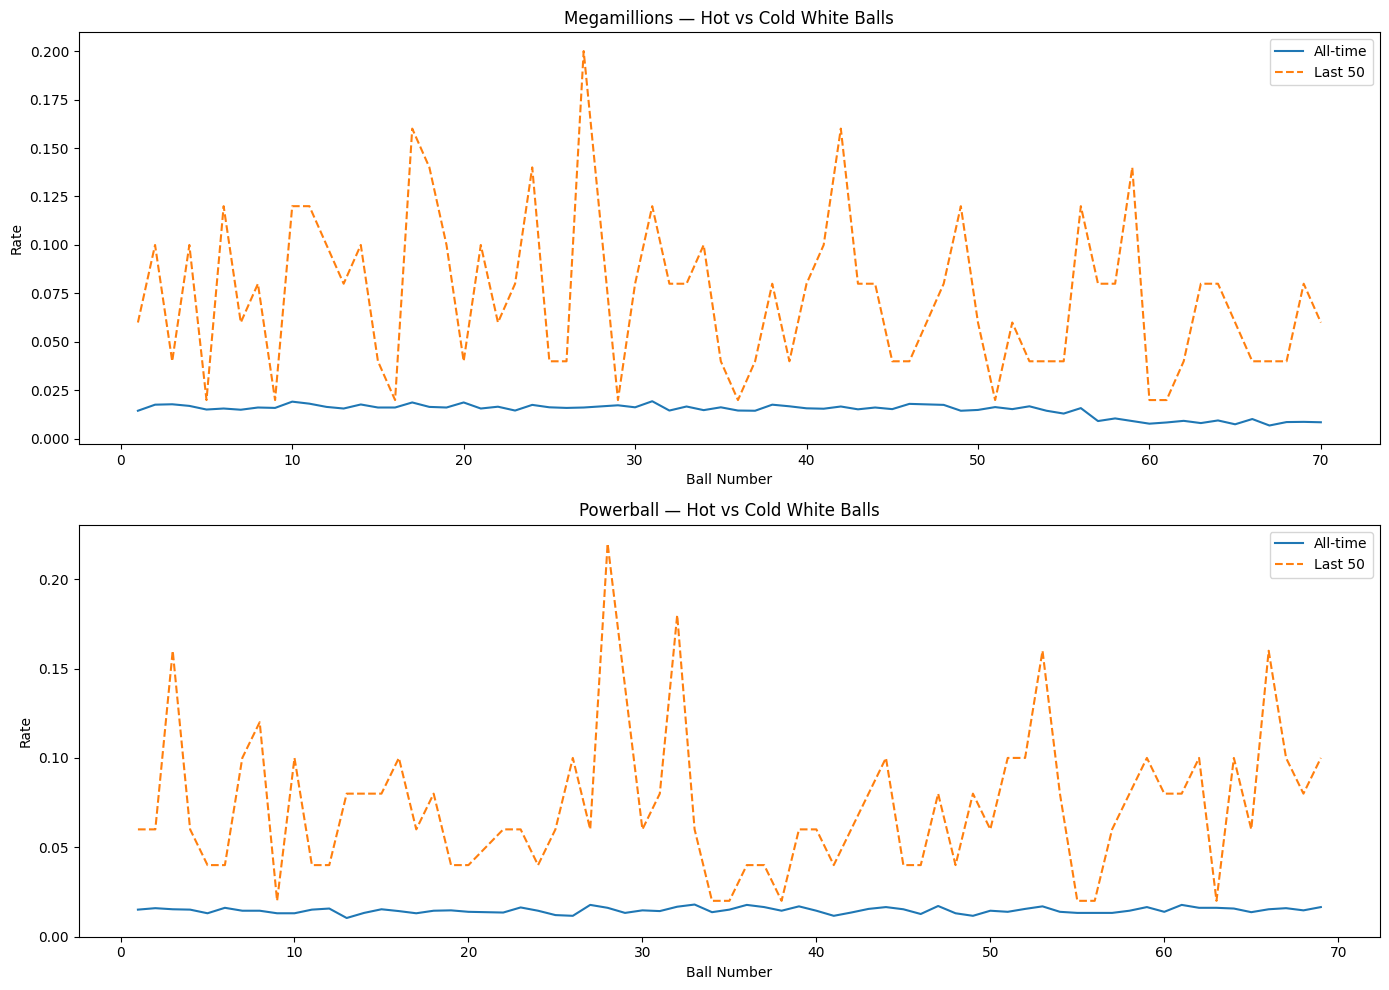

In [3]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("../data/raw")

pb = json.loads((DATA_DIR / "powerball_draws.json").read_text())
mm = json.loads((DATA_DIR / "megamillions_draws.json").read_text())

df = pd.concat([pd.DataFrame(pb), pd.DataFrame(mm)], ignore_index=True)
df["draw_date"] = pd.to_datetime(df["draw_date"], format="mixed")

RECENT_N = 50

recent = (
    df.sort_values("draw_date")
      .groupby("game")
      .tail(RECENT_N)
      .explode("white_numbers")
      .rename(columns={"white_numbers": "white_ball"})
)

all_time = (
    df.explode("white_numbers")
      .rename(columns={"white_numbers": "white_ball"})
)

recent_freq = (
    recent.groupby(["game", "white_ball"])
          .size()
          .reset_index(name="recent_count")
)

all_freq = (
    all_time.groupby(["game", "white_ball"])
            .size()
            .reset_index(name="all_time_count")
)

freq = recent_freq.merge(all_freq, on=["game", "white_ball"], how="left")

# Normalize
freq["recent_rate"] = freq["recent_count"] / RECENT_N
freq["all_time_rate"] = (
    freq.groupby("game")["all_time_count"]
        .transform(lambda x: x / x.sum())
)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for ax, game in zip(axes, freq["game"].unique()):
    gdf = freq[freq["game"] == game]
    ax.plot(gdf["white_ball"], gdf["all_time_rate"], label="All-time")
    ax.plot(gdf["white_ball"], gdf["recent_rate"], label=f"Last {RECENT_N}", linestyle="--")
    ax.set_title(f"{game.capitalize()} — Hot vs Cold White Balls")
    ax.set_xlabel("Ball Number")
    ax.set_ylabel("Rate")
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Statistical Tests Require Assumptions

Statistical tests can quantify whether observed deviations are consistent
with randomness. However, every test relies on assumptions about how
the data was generated.

Violating these assumptions can lead to misleading conclusions.


## 4. When a Test Fails for the Right Reason

A statistically significant result does not necessarily imply bias,
manipulation, or non-randomness.

In some cases, it indicates that the assumptions of the test
do not align with the structure of the data.

## 5. Asking the Correct Question

Rather than asking whether a lottery is random across its entire history,
a more appropriate question is whether it behaves randomly
within a consistent rule set.

## 6. Key Takeaways

- Random systems do not produce visually uniform outcomes.
- Short-term trends exaggerate variance and invite false narratives.
- Statistical tests are only meaningful when their assumptions hold.
- Apparent patterns often collapse under proper analytical framing.